# load dependencies 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load data

In [2]:
df = pd.read_csv("../data/customer_segmentation_data.csv")
dfs = pd.read_excel("../data/Segmentation data legend.xlsx")

In [3]:
df.head(4)

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4


In [4]:
dfs.head(4)

,Unnamed: 0,Segmentation data - Legend,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,The dataset consists of student information of...,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,Variable,Data type,Range,Description
3,NaN,minutes watched,numerical,Integer,The number of minutes a student has watched si...


# extracting metadata from segmentation data legend 

- customer segmentation data have 4 columns
    1. minutes watched
    2. CLV
    3. region
    4. channel

### miutes watched 
- The number of minutes a student has watched since joining the program
- type: integer

### CLV
- total predicted revenue a business can expect from a single customer throughout their entire relationship with the company.
- It's a forward-looking metric that helps businesses understand long-term customer value to make strategic decisions about customer acquisition and retention
- type: integer

### Region
- This is the geographical region where the student comes from.
    - regions
        - `0` : USA , Canada ,Australia , UK
        - `1` : Western Europe
        - `2` : Rest of the world
 
### Channel
- This is the channel through which the customer has learned about the 365 program

   number  channel   
-------------::-------------
            1  Google       
            2  Facebook     
            3  YouTube      
            4  LinkedIn     
            5  Twitter      
            6  Instagram    
            7  Friend       
            8  Other        


---
# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


- we found that there is a column "minutes_watched" that have NaN values
- let's handle it 

## Handling Nan values 

In [6]:
df["minutes_watched"].isna().sum()

np.int64(109)

In [7]:
filt = df["minutes_watched"].isna()
df[filt]

,minutes_watched,CLV,region,channel
215,NaN,300.06,0,4
368,NaN,43.82,1,3
470,NaN,150.28,0,6
545,NaN,149.99,2,3
764,NaN,62.58,2,6
...,...,...,...,...
3809,NaN,79.00,0,3
3813,NaN,94.80,2,4
3816,NaN,94.01,1,4
3822,NaN,79.00,0,3


In [8]:
# seeing the CLV of Nan values in "minutes_watched" column
df[filt].loc[:,"CLV"].mean()

np.float64(132.73614678899082)

- the only column contains Nan values is column "minutes_watched" 
- there are some values that have a big CLV
- so I suspect that the Nan values are not zeros , they are just not provided
- the strategy is to replace the Nan values with a proper value
- the best way is to replace Nan values with find the crossponding median to it's segment
    - segment the data (group by) by region and  channel then find the median

In [9]:
df.columns

Index(['minutes_watched', 'CLV', 'region', 'channel'], dtype='object')

In [10]:
df1 = df.groupby(by= ["region" , "channel"])

In [11]:
df1.get_group((0 , 4))

,minutes_watched,CLV,region,channel
11,611.0,149.99,0,4
36,61.0,149.99,0,4
38,315.0,149.98,0,4
52,980.0,359.03,0,4
215,NaN,300.06,0,4
...,...,...,...,...
3688,NaN,156.00,0,4
3712,1715.0,174.00,0,4
3720,151.0,174.00,0,4
3819,3.0,79.00,0,4


In [12]:
median_values = df1["minutes_watched"].transform('median')

In [13]:
# returns repeated median values for each row 
median_values

0       588.0
1       299.0
2       762.5
3       588.0
4       411.5
        ...  
3829    380.5
3830    309.0
3831    762.5
3832    785.0
3833    380.5
Name: minutes_watched, Length: 3834, dtype: float64

In [14]:
# replacing the Nan values 
df["minutes_watched"] = df["minutes_watched"].fillna(median_values)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3834 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


---
## Visualization 

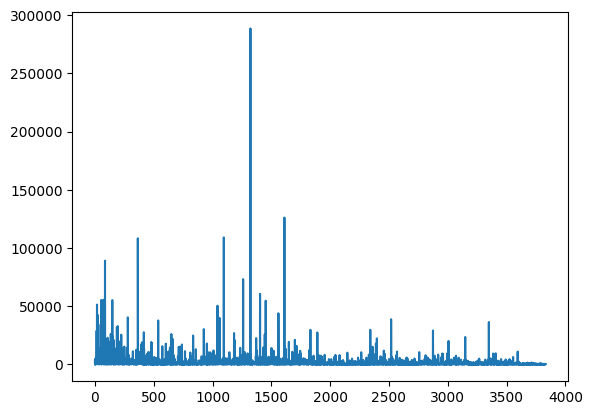

In [16]:
plt.plot(df["minutes_watched"])

### checking Distribution

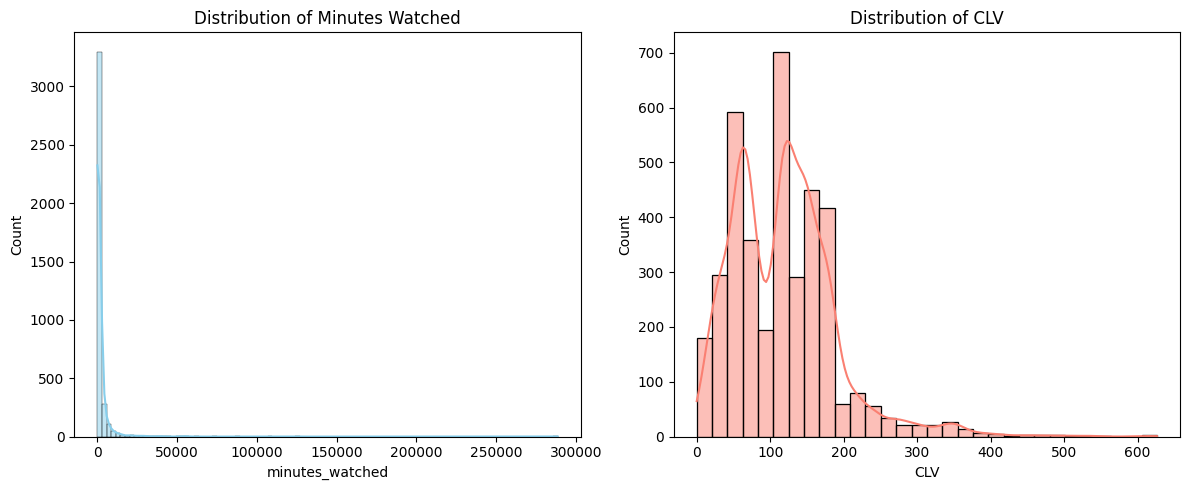

In [17]:
plt.figure(figsize=(12,5))

# minutes_watched
plt.subplot(1, 2, 1)
sns.histplot(df['minutes_watched'], kde=True, bins=100, color='skyblue')
plt.title('Distribution of Minutes Watched')

# CLV
plt.subplot(1, 2, 2)
sns.histplot(df['CLV'], kde=True, bins=30, color='salmon')
plt.title('Distribution of CLV')

plt.tight_layout()
plt.show()


### check outliers

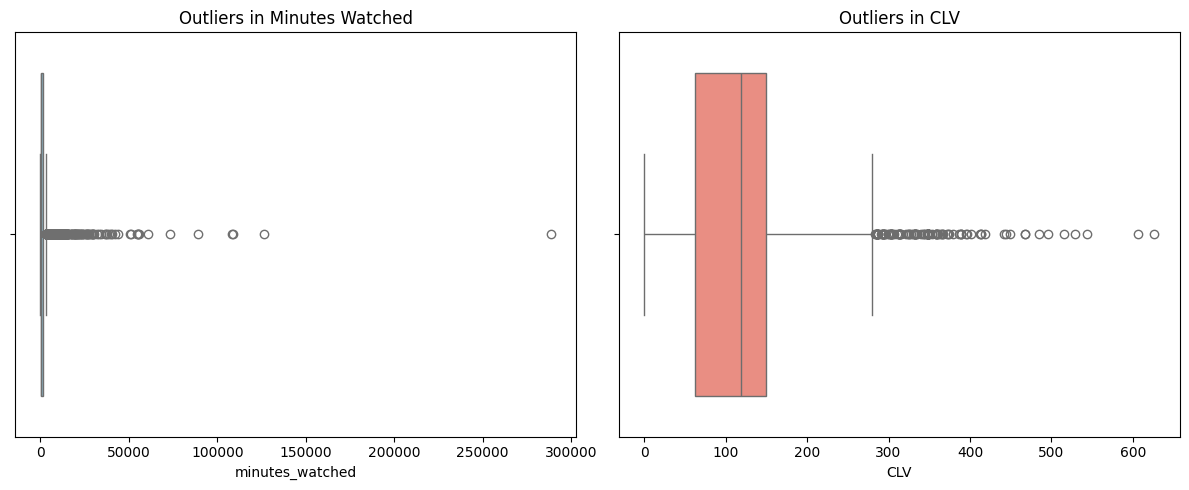

In [18]:
plt.figure(figsize=(12,5))

# minutes_watched
plt.subplot(1, 2, 1)
sns.boxplot(x=df['minutes_watched'], color='skyblue')
plt.title('Outliers in Minutes Watched')

# CLV
plt.subplot(1, 2, 2)
sns.boxplot(x=df['CLV'], color='salmon')
plt.title('Outliers in CLV')

plt.tight_layout()
plt.show()


In [19]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower) | (df[column] > upper)]
    return outliers, lower, upper

outliers_mw, low_mw, up_mw = detect_outliers(df, 'minutes_watched')
outliers_clv, low_clv, up_clv = detect_outliers(df, 'CLV')

print(f"Minutes_watched outliers: {len(outliers_mw)} rows")
percent = len(outliers_mw)/len(df)*100
print("percent: {:.1f} %".format(percent))
print("")
print(f"CLV outliers: {len(outliers_clv)} rows")
percent = len(outliers_clv)/len(df)*100
print("percent: {:.1f} %".format(percent))

Minutes_watched outliers: 444 rows
percent: 11.6 %

CLV outliers: 120 rows
percent: 3.1 %


## My Analysis
- I found 444 rows in the minutes_watched column (representing 11.6% of the data) that are classified as outliers.
- In the CLV column, I identified 120 rows (representing 3.1%) as outliers.

## Strategy
- Keep the outliers in minutes_watched since they reflect real user behavior.
- Adjust the upper whisker for CLV, as this column is calculated and extreme values may distort the analysis.

# handling Outliers and applying strategy

- the plan is to design a function that clip the upper whisker of outliers and keep the lower value

In [20]:
def clip_upper_whisker(s):
    Q1 = s.quantile(0.25)
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    return np.where(s > upper, upper, s)

df['CLV_wins'] = clip_upper_whisker(df['CLV'])

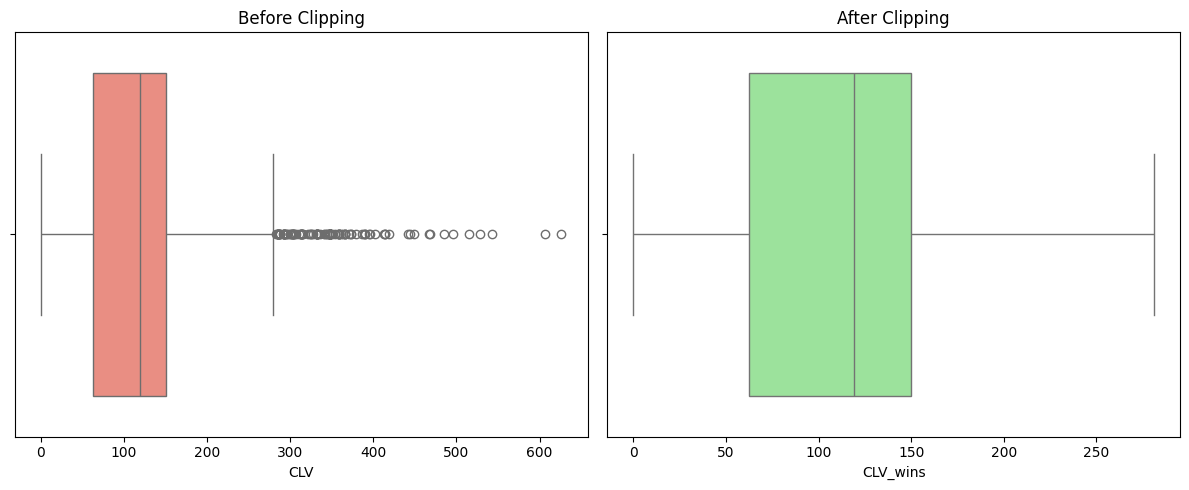

In [21]:
# seeing the difference 

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x=df['CLV'], color='salmon')
plt.title('Before Clipping')

plt.subplot(1,2,2)
sns.boxplot(x=df['CLV_wins'], color='lightgreen')
plt.title('After Clipping')

plt.tight_layout()
plt.show()

---

# Visualization data

- modifing and saving data for visualization 

In [22]:
region_map = {0:"USA/Canada/As" , 1:"West_EU" , 2:"Rest_of_the_world"}
channel_map = {1 : "Google",       
            2 : "Facebook",     
            3 : "YouTube",      
            4 : "LinkedIn",     
            5 : "Twitter",      
            6 : "Instagram",    
            7 : "Friend",       
            8 : "Other"}

In [23]:
visual_df = df.copy()

In [24]:
visual_df['Region'] = visual_df["region"].map(region_map)

In [25]:
visual_df["Channel"] = visual_df["channel"].map(channel_map)

In [26]:
visual_df.head()

,minutes_watched,CLV,region,channel,CLV_wins,Region,Channel
0,3197.0,205.42,2,4,205.42,Rest_of_the_world,LinkedIn
1,63.0,149.99,0,1,149.99,USA/Canada/As,Google
2,605.0,119.00,2,2,119.00,Rest_of_the_world,Facebook
3,20.0,240.00,2,4,240.00,Rest_of_the_world,LinkedIn
4,245.0,184.36,1,4,184.36,West_EU,LinkedIn


In [27]:
# saving data
visual_df.to_csv("../data/visual_data.csv" , index=False)

# preprocessing 

## encoding

- in my opinion , we need to apply KFold Target Encoding
- since all data is Discrete Nominal Categorical , we need a type of encoding that do not put any order
#### problem
- we do not have a target column , the columns that meant to be encoded is the target columns

#### Strategy 
- according to what we will use
    1. if we are using `k-means` , then we need one-hot-encoding
    2. if we are using `k-prototypes` (good for hetrogenous data) we will need to map cols to categorical cols   

---
### Encoding for K-prototyping

In [28]:
# modifing data 
## drop old columns 
df = df.drop(columns={"region" , "channel"})

## get mapped columns from visual_df
df["Region"] = visual_df["Region"]
df["Channel"] = visual_df["Channel"]

In [29]:
df.columns = [s.lower() for s in df.columns]
df

,minutes_watched,clv,clv_wins,region,channel
0,3197.0,205.42,205.42,Rest_of_the_world,LinkedIn
1,63.0,149.99,149.99,USA/Canada/As,Google
2,605.0,119.00,119.00,Rest_of_the_world,Facebook
3,20.0,240.00,240.00,Rest_of_the_world,LinkedIn
4,245.0,184.36,184.36,West_EU,LinkedIn
...,...,...,...,...,...
3829,11.0,79.00,79.00,USA/Canada/As,YouTube
3830,28.0,79.00,79.00,USA/Canada/As,Facebook
3831,57.0,36.00,36.00,Rest_of_the_world,Facebook
3832,44.0,36.00,36.00,Rest_of_the_world,Google


In [30]:
# saving data for k-prototype
df.to_csv("../data/k_pro_data.csv")

### Encoding data for k-means

In [31]:
df["region"] = visual_df["Region"]

In [32]:
df

,minutes_watched,clv,clv_wins,region,channel
0,3197.0,205.42,205.42,Rest_of_the_world,LinkedIn
1,63.0,149.99,149.99,USA/Canada/As,Google
2,605.0,119.00,119.00,Rest_of_the_world,Facebook
3,20.0,240.00,240.00,Rest_of_the_world,LinkedIn
4,245.0,184.36,184.36,West_EU,LinkedIn
...,...,...,...,...,...
3829,11.0,79.00,79.00,USA/Canada/As,YouTube
3830,28.0,79.00,79.00,USA/Canada/As,Facebook
3831,57.0,36.00,36.00,Rest_of_the_world,Facebook
3832,44.0,36.00,36.00,Rest_of_the_world,Google


In [33]:
region_dummies = pd.get_dummies(df , columns=["region"], drop_first=True).select_dtypes(bool).astype(int)
df = pd.concat([df , region_dummies] , axis=1)

In [34]:
df.drop(columns={"region"} , inplace=True)

In [35]:
channel_dum = pd.get_dummies(df , columns=["channel"] , drop_first=True).select_dtypes(bool).astype(int)
df = pd.concat([df , channel_dum] , axis=1)
df.drop(columns={"channel"})

,minutes_watched,clv,clv_wins,region_USA/Canada/As,region_West_EU,channel_Friend,channel_Google,channel_Instagram,channel_LinkedIn,channel_Other,channel_Twitter,channel_YouTube
0,3197.0,205.42,205.42,0,0,0,0,0,1,0,0,0
1,63.0,149.99,149.99,1,0,0,1,0,0,0,0,0
2,605.0,119.00,119.00,0,0,0,0,0,0,0,0,0
3,20.0,240.00,240.00,0,0,0,0,0,1,0,0,0
4,245.0,184.36,184.36,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,79.00,1,0,0,0,0,0,0,0,1
3830,28.0,79.00,79.00,1,0,0,0,0,0,0,0,0
3831,57.0,36.00,36.00,0,0,0,0,0,0,0,0,0
3832,44.0,36.00,36.00,0,0,0,1,0,0,0,0,0


In [38]:
df.drop(columns={"channel"} , inplace=True)

In [39]:
# showing the final result
df

,minutes_watched,clv,clv_wins,region_USA/Canada/As,region_West_EU,channel_Friend,channel_Google,channel_Instagram,channel_LinkedIn,channel_Other,channel_Twitter,channel_YouTube
0,3197.0,205.42,205.42,0,0,0,0,0,1,0,0,0
1,63.0,149.99,149.99,1,0,0,1,0,0,0,0,0
2,605.0,119.00,119.00,0,0,0,0,0,0,0,0,0
3,20.0,240.00,240.00,0,0,0,0,0,1,0,0,0
4,245.0,184.36,184.36,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3829,11.0,79.00,79.00,1,0,0,0,0,0,0,0,1
3830,28.0,79.00,79.00,1,0,0,0,0,0,0,0,0
3831,57.0,36.00,36.00,0,0,0,0,0,0,0,0,0
3832,44.0,36.00,36.00,0,0,0,1,0,0,0,0,0


In [40]:
# saving data for k-means 
df.to_csv("../data/kmeans_data.csv" , index=False)